Import required resources

In [ ]:
#import the necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

In [ ]:
try:
    # Attempt to resolve and connect to a TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f"Running on TPU: {tpu.cluster_spec().as_dict()}")
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    # If no TPU is found, check for available GPUs
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"Running on GPU: {gpus[0].name}")
    else:
        cpus = tf.config.list_physical_devices('CPU')
        print(f"Running on CPU: {cpus[0].name}")

Running on TPU: {}


Dataset loading/splitting

In [ ]:
# Load dataset with proper split
train_dataset, val_dataset, test_dataset = tfds.load(
    'patch_camelyon',
    split=['train[:85%]', 'train[85%:]', 'test'], #split train dataset to 85% train and 15% validation
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/32768 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/patch_camelyon/incomplete.OD2IZ8_2.0.0/patch_camelyon-test.tfrecord*...:  …

Generating train examples...:   0%|          | 0/262144 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/patch_camelyon/incomplete.OD2IZ8_2.0.0/patch_camelyon-train.tfrecord*...: …

Generating validation examples...:   0%|          | 0/32768 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/patch_camelyon/incomplete.OD2IZ8_2.0.0/patch_camelyon-validation.tfrecord*…

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [ ]:
#print the number of train, test and validation data
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of test examples: {len(test_dataset)}")

Number of training examples: 222822
Number of validation examples: 39322
Number of test examples: 32768


In [ ]:
# Preprocess the dataset
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

train_dataset = (train_dataset
                 .map(preprocess)
                 .shuffle(1000)
                 .cache()
                 .batch(32)
                 .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset = (val_dataset
               .map(preprocess)
               .cache()
               .batch(32)
               .prefetch(tf.data.experimental.AUTOTUNE))

test_dataset = (test_dataset
                .map(preprocess)
                .cache()
                .batch(32)
                .prefetch(tf.data.experimental.AUTOTUNE))


Displaying the images

In [ ]:
import matplotlib.pyplot as plt

# Function to plot images from a dataset
def plot_images(dataset, num_images=10): #num_images: Number of images to display
    plt.figure(figsize=(12, 6))
    images_plotted = 0

    # Loop through batches of images and labels in the dataset
    for images, labels in dataset:
        # Loop through individual images within a batch
        for i in range(images.shape[0]):
            if images_plotted < num_images:
                plt.subplot(2, 5, images_plotted + 1)
                plt.imshow(images[i].numpy())
                plt.title(f"Label: {labels[i].numpy():.0f}")
                plt.axis('off')
                images_plotted += 1
            else:
                break
        if images_plotted >= num_images:
            break

    plt.tight_layout()
    plt.show()

#display images from the training dataset
print("Train Dataset Images:")
plot_images(train_dataset)

#display images from the test dataset
print("Test Dataset Images:")
plot_images(test_dataset)

Output hidden; open in https://colab.research.google.com to view.

Building the CNN extended epochs model

In [ ]:
"""
    Builds and compiles a Convolutional Neural Network (CNN) for binary classification.

    Returns a compiled TensorFlow Keras model.

"""

def build_model_1():
    model = models.Sequential()

    # Add the first convolutional layer with 64 filters and a ReLU activation function
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Add the second convolutional layer with 128 filters
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    # Add the third convolutional layer with 128 filters
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Add the fourth convolutional layer with 256 filters
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))

    # Add a dense layer with 256 units and ReLU activatio
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid')) # Add the final output layer with a single unit and sigmoid activation for binary classification

    # Compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy metric
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
model = build_model_1()

# Train the model on the training dataset
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    verbose=1)


Epoch 1/20
6964/6964 [==============================] - 903s 129ms/step - loss: 0.4436 - accuracy: 0.7947 - val_loss: 0.4296 - val_accuracy: 0.7975
Epoch 2/20
6964/6964 [==============================] - 882s 127ms/step - loss: 0.3230 - accuracy: 0.8642 - val_loss: 0.3176 - val_accuracy: 0.8618
Epoch 3/20
6964/6964 [==============================] - 880s 126ms/step - loss: 0.2682 - accuracy: 0.8902 - val_loss: 0.2634 - val_accuracy: 0.8885
Epoch 4/20
6964/6964 [==============================] - 878s 126ms/step - loss: 0.2335 - accuracy: 0.9072 - val_loss: 0.2080 - val_accuracy: 0.9181
Epoch 5/20
6964/6964 [==============================] - 879s 126ms/step - loss: 0.2115 - accuracy: 0.9169 - val_loss: 0.1840 - val_accuracy: 0.9305
Epoch 6/20
6964/6964 [==============================] - 880s 126ms/step - loss: 0.1949 - accuracy: 0.9241 - val_loss: 0.1642 - val_accuracy: 0.9409
Epoch 7/20
6964/6964 [==============================] - 878s 126ms/step - loss: 0.1833 - accuracy: 0.9297 - val_

Prediction overview and Evaluation metrics

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0) # Concatenate the true labels from the test dataset into a single array
y_pred_probs = model.predict(test_dataset) # Get the predicted probabilities from the model for the test dataset
y_pred = (y_pred_probs > 0.5).astype(int) # Convert probabilities to binary predictions (1 if > 0.5, else 0)

# Calculate performance metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

1024/1024 [==============================] - 30s 29ms/step
Accuracy: 0.786
F1 Score: 0.736


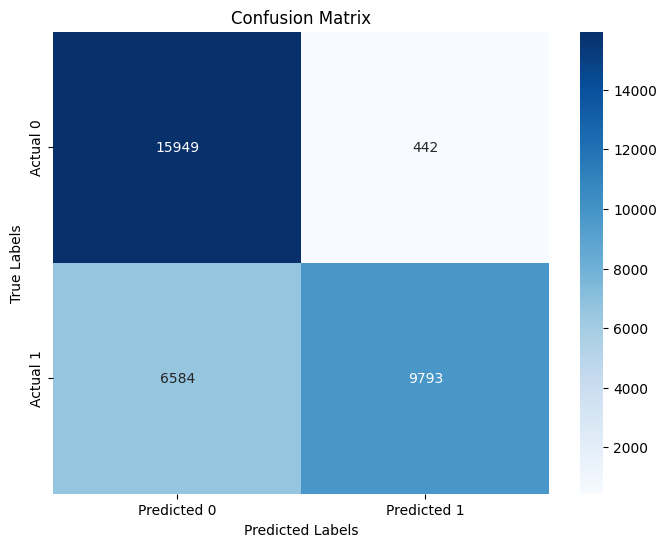

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute and plot the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


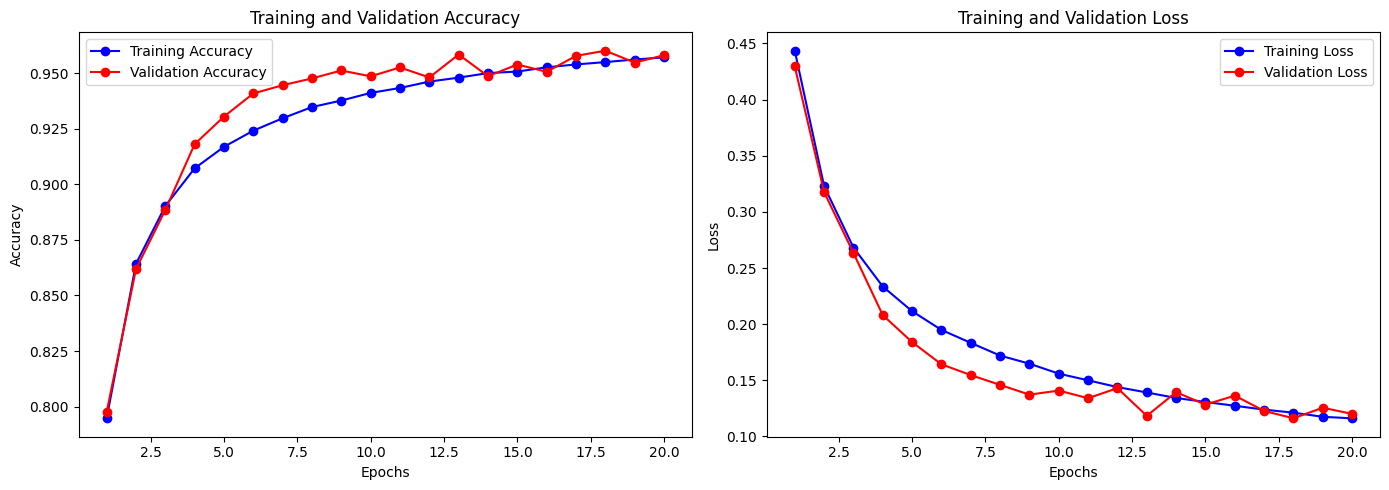

In [ ]:
import matplotlib.pyplot as plt

# Extract values for accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Baseline CNN: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Baseline CNN: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Saving the trained model to the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_save_path = '/content/drive/My Drive/PCAM_MODEL_WEIGHTS/model_CNN.h5'

model.save(model_save_path)

Mounted at /content/drive
